# Prediction

### Data

In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb

# 加载数据
# df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/^GSPC.csv', parse_dates=['Date'], index_col='Date')
df = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/^GSPC.csv')

# 数据预处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# 创建数据集
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 3
X, y = create_dataset(scaled_data, time_step)

# 数据集划分为训练集和测试集，按 7:3 划分
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 转换为 PyTorch 张量
X_train = torch.FloatTensor(X_train).view(-1, time_step, 1)
y_train = torch.FloatTensor(y_train).view(-1, 1)
X_test = torch.FloatTensor(X_test).view(-1, time_step, 1)
y_test = torch.FloatTensor(y_test).view(-1, 1)


### LSTM


#### (1) Only Index data

In [ ]:
test_mse = []
for j in range(1):
  class Attention(nn.Module):
      def __init__(self, hidden_size):
          super(Attention, self).__init__()
          self.Wa = nn.Linear(hidden_size, hidden_size)
          self.Ua = nn.Linear(hidden_size, hidden_size)
          self.Va = nn.Linear(hidden_size, 1)

      def forward(self, lstm_out):
          scores = self.Va(torch.tanh(self.Wa(lstm_out) + self.Ua(lstm_out)))
          attention_weights = torch.softmax(scores, dim=1)
          context_vector = torch.sum(attention_weights * lstm_out, dim=1)
          return context_vector

  class TemporalAttentionLSTM(nn.Module):
      def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
          super(TemporalAttentionLSTM, self).__init__()
          self.hidden_layer_size = hidden_layer_size
          self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
          self.attention = Attention(hidden_layer_size)
          self.linear = nn.Linear(hidden_layer_size, output_size)
          self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                              torch.zeros(1, 1, self.hidden_layer_size))

      def forward(self, input_seq):
          lstm_out, self.hidden_cell = self.lstm(input_seq)
          context_vector = self.attention(lstm_out)
          predictions = self.linear(context_vector)
          return predictions

  model = TemporalAttentionLSTM(input_size=X_train.shape[2])
  loss_function = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)

  # 训练模型
  epochs = 60
  for i in range(epochs):
      model.train()
      for seq, labels in zip(X_train, y_train):
          optimizer.zero_grad()
          model.hidden_cell = (torch.zeros(1, seq.size(0), model.hidden_layer_size),
                              torch.zeros(1, seq.size(0), model.hidden_layer_size))
          y_pred = model(seq.unsqueeze(0))  # Add batch dimension
          single_loss = loss_function(y_pred, labels.unsqueeze(0))  # Add batch dimension
          single_loss.backward()
          optimizer.step()
      # if i % 10 == 0:
      #     print(f'Epoch {i} Loss: {single_loss.item()}')

  # 预测
  model.eval()
  train_preds = []
  test_preds = []

  with torch.no_grad():
      for seq in X_train:
          model.hidden_cell = (torch.zeros(1, seq.size(0), model.hidden_layer_size),
                              torch.zeros(1, seq.size(0), model.hidden_layer_size))
          train_preds.append(model(seq.unsqueeze(0)).item())

      for seq in X_test:
          model.hidden_cell = (torch.zeros(1, seq.size(0), model.hidden_layer_size),
                              torch.zeros(1, seq.size(0), model.hidden_layer_size))
          test_preds.append(model(seq.unsqueeze(0)).item())
  mse = mean_squared_error(y_test, test_preds)
  print(f'epoch {j+1} mse: {mse}')
  test_mse.append(mse)
print(f'Test MSE: {sum(test_mse)/10}')

epoch 1 mse: 0.0012521725951220848
Test MSE: 0.0001252172595122085


Train MSE: 0.004498680615687294
Test MSE: 0.0012521725951220848


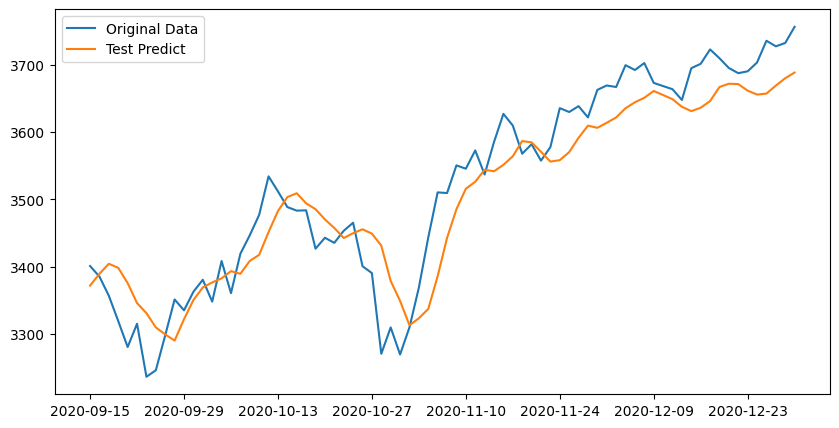

In [ ]:
# 计算 MSE 使用标准化后的数据
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

# 转换回原始值
train_preds = scaler.inverse_transform(np.array(train_preds).reshape(-1, 1))
test_preds = scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))

# 计算 MSE
# train_mse = mean_squared_error(scaler.inverse_transform(y_train.reshape(-1, 1)), train_preds)
# test_mse = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), test_preds)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(df['Date'][train_size + time_step:], scaler.inverse_transform(scaled_data[train_size + time_step:]), label='Original Data')
# plt.plot(df['Date'][time_step:train_size + time_step], train_preds, label='Train Predict')
plt.plot(df['Date'][train_size + time_step:], test_preds, label='Test Predict')
plt.xticks(ticks=df['Date'][train_size + time_step:][::10], rotation=0)
plt.legend()
plt.savefig("Only Index.png", dpi=300, bbox_inches='tight')
plt.show()

#### (2) Add Emotion data

##### One-Hot

In [ ]:
df_emotion = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/train_stockemo.csv')

# 独热编码12维
def emo_2_vec(emotion):
    emo_list = ['ambiguous', 'amusement', 'anger', 'anxiety', 'belief', 'confusion',
                'depression', 'disgust', 'excitement', 'optimism', 'panic', 'surprise']
    idx = emo_list.index(emotion)
    return np.array([1 if i == idx else 0 for i in range(12)])

# 合并情感数据
def aggregate_emotion(df_emotion):
    # df_emotion['embedding'] = text_to_embedding(df_emotion['emo_label'], embeddings_index, embed_dim).tolist()
    df_emotion['emotion_embedding_diy'] = df_emotion['emo_label'].apply(emo_2_vec).tolist()
    aggregated = df_emotion.groupby('date')['emotion_embedding_diy'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
    return aggregated

# 处理情感数据
df_emotion_aggregated = aggregate_emotion(df_emotion)

# 合并价格数据和情感数据
df['date'] = pd.to_datetime(df['Date'])
df_emotion_aggregated['date'] = pd.to_datetime(df_emotion_aggregated['date'])

df_combined = pd.merge(df, df_emotion_aggregated, on='date', how='left')
# 处理缺失值
df_combined.dropna(inplace=True)
# df_combined
# daily_emotion_embedding = df_emotion.groupby('date')['emotion_embedding_diy'].apply(lambda x: np.sum(np.stack(x), axis=0)/len(np.stack(x)))
# emotion_embeddings_combined = np.array()
# emotion_embeddings_combined = pca.fit_transform(daily_emotion_embedding)

In [ ]:
# 提取价格和情感嵌入
prices_combined = df_combined['Close'].values
# prices_combined = df_combined
emotion_embeddings_combined = np.array(df_combined['emotion_embedding_diy'].tolist())
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
emotion_embeddings_combined = pca.fit_transform(emotion_embeddings_combined)
# print(emotion_embeddings_combined)
from sklearn.preprocessing import StandardScaler
# 标准化价格数据
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled_combined = scaler.fit_transform(prices_combined.reshape(-1, 1))
# prices_scaled_combined = scaler.fit_transform(prices_combined.iloc[:,1:7])

# 数据准备函数
def prepare_data_with_emotion(prices, emotions, sequence_length):
    X, y = [], []
    for i in range(len(prices) - sequence_length):
        price_seq = prices[i:i+sequence_length]
        emotion_seq = emotions[i:i+sequence_length]
        combined_seq = np.hstack([price_seq, emotion_seq])
        X.append(combined_seq)
        y.append(prices[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 3
X_combined, y_combined = prepare_data_with_emotion(prices_scaled_combined, emotion_embeddings_combined, sequence_length)

# 划分数据集
train_size_combined = int(len(X_combined) * 0.7)
X_train_combined, X_test_combined = X_combined[:train_size_combined], X_combined[train_size_combined:]
y_train_combined, y_test_combined = y_combined[:train_size_combined], y_combined[train_size_combined:]

# 转换为 PyTorch 张量
X_train_combined_torch = torch.FloatTensor(X_train_combined)
X_test_combined_torch = torch.FloatTensor(X_test_combined)
y_train_combined_torch = torch.FloatTensor(y_train_combined)
y_test_combined_torch = torch.FloatTensor(y_test_combined)

In [ ]:
test_mse = []
times = 1
for j in range(times):
  class Attention(nn.Module):
      def __init__(self, hidden_size):
          super(Attention, self).__init__()
          self.Wa = nn.Linear(hidden_size, hidden_size)
          self.Ua = nn.Linear(hidden_size, hidden_size)
          self.Va = nn.Linear(hidden_size, 1)

      def forward(self, lstm_out):
          scores = self.Va(torch.tanh(self.Wa(lstm_out) + self.Ua(lstm_out)))
          attention_weights = torch.softmax(scores, dim=1)
          context_vector = torch.sum(attention_weights * lstm_out, dim=1)
          return context_vector

  class TemporalAttentionLSTM(nn.Module):
      def __init__(self, input_size=1, hidden_layer_size=25, output_size=1):
          super(TemporalAttentionLSTM, self).__init__()
          self.hidden_layer_size = hidden_layer_size
          self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
          self.attention = Attention(hidden_layer_size)
          self.linear = nn.Linear(hidden_layer_size, output_size)
          self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                              torch.zeros(1, 1, self.hidden_layer_size))

      def forward(self, input_seq):
          lstm_out, self.hidden_cell = self.lstm(input_seq)
          context_vector = self.attention(lstm_out)
          predictions = self.linear(context_vector)
          return predictions

  # 实例化模型、定义损失函数和优化器
  input_size_combined = X_train_combined_torch.shape[2]  # X_train_combined 的特征维度
  model_combined = TemporalAttentionLSTM(input_size=input_size_combined, hidden_layer_size=100, output_size=1)
  loss_function_combined = nn.MSELoss()
  optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.01)

  # 训练模型
  epochs =300
  for i in range(epochs):
      model_combined.train()
      optimizer_combined.zero_grad()
      y_pred_combined = model_combined(X_train_combined_torch)
      single_loss_combined = loss_function_combined(y_pred_combined, y_train_combined_torch)
      single_loss_combined.backward()
      optimizer_combined.step()
      # if i % 10 == 0:
      #     print(f'Epoch {i} Loss: {single_loss_combined.item()}')

  # 预测
  model_combined.eval()
  train_preds_combined = []
  test_preds_combined = []

  with torch.no_grad():
      for seq in X_train_combined_torch:
          train_preds_combined.append(model_combined(seq.unsqueeze(0)).item())

      for seq in X_test_combined_torch:
          test_preds_combined.append(model_combined(seq.unsqueeze(0)).item())

  mse = mean_squared_error(y_test_combined, test_preds_combined)
  print(f'epoch {j+1} mse: {mse}')
  test_mse.append(mse)
print(f'Test MSE: {sum(test_mse)/times}')

epoch 1 mse: 0.0008662298279676887
Test MSE: 0.0008662298279676887


Train MSE: 0.00184555468211529
Test MSE: 0.0008662298279676887


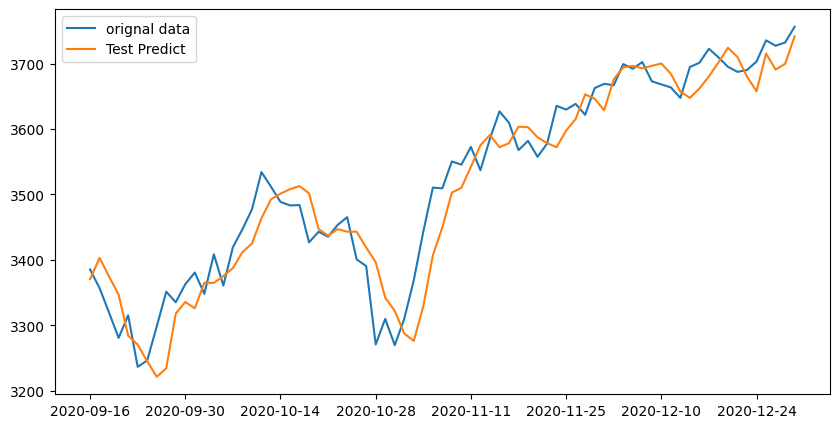

In [ ]:
# 计算 MSE 使用标准化后的数据
train_mse_combined = mean_squared_error(y_train_combined, train_preds_combined)
test_mse_combined = mean_squared_error(y_test_combined, test_preds_combined)

# 转换回原始值
# train_preds = scaler.inverse_transform(np.array(train_preds_combined).reshape(-1, 1))
# test_preds = scaler.inverse_transform(np.array(test_preds_combined).reshape(-1, 1))
train_preds_combined = np.array(train_preds_combined).reshape(-1, 1)
test_preds_combined = np.array(test_preds_combined).reshape(-1, 1)

print(f'Train MSE: {train_mse_combined}')
print(f'Test MSE: {test_mse_combined}')

# 绘图
plt.figure(figsize=(10, 5))
# plt.plot(df['Date'][1:], scaler.inverse_transform(prices_scaled_combined), label='Original Data')
# plt.plot(df['Date'][sequence_length:train_size_combined + sequence_length], scaler.inverse_transform(train_preds_combined), label='Train Predict')
plt.plot(df['Date'][train_size_combined + sequence_length+1:], scaler.inverse_transform(prices_scaled_combined[train_size_combined + sequence_length:]), label='orignal data')
plt.plot(df['Date'][train_size_combined + sequence_length+1:], scaler.inverse_transform(test_preds_combined), label='Test Predict')
plt.xticks(ticks=df['Date'][train_size_combined + sequence_length+1:][::10], rotation=0)
plt.legend()
plt.savefig("Index+Emo(One-Hot).png", dpi=300, bbox_inches='tight')
plt.show()

##### GloVe

In [ ]:
import numpy as np

# 加载 GloVe 嵌入
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# 将单词标签转换为嵌入
def text_to_embedding(texts, embeddings_index, embed_dim):
    embeddings = []
    for text in texts:
        words = text.split()
        word_embeddings = np.zeros(embed_dim)
        count = 0
        for word in words:
            if word in embeddings_index:
                word_embeddings += embeddings_index[word]
                count += 1
        if count > 0:
            word_embeddings /= count
        embeddings.append(word_embeddings)
    return np.array(embeddings)

# 加载情感标签数据
df_emotion = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/train_stockemo.csv')
# emotion_texts = df_emotion['emo_label'].astype(str).values
# emotion_texts

In [ ]:
# 合并情感数据
def aggregate_emotion(df_emotion, embeddings_index, embed_dim):
    df_emotion['embedding'] = text_to_embedding(df_emotion['emo_label'], embeddings_index, embed_dim).tolist()
    aggregated = df_emotion.groupby('date')['embedding'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
    return aggregated

# 处理情感数据
embed_dim = 50  # GloVe 嵌入维度
glove_file = '/content/drive/MyDrive/Sentiment Analysis/glove.6B.50d.txt'
embeddings_index = load_glove_embeddings(glove_file)
df_emotion_aggregated = aggregate_emotion(df_emotion, embeddings_index, embed_dim)

# 合并价格数据和情感数据
df['date'] = pd.to_datetime(df['Date'])
df_emotion_aggregated['date'] = pd.to_datetime(df_emotion_aggregated['date'])

df_combined = pd.merge(df, df_emotion_aggregated, on='date', how='left')
# 处理缺失值
df_combined.dropna(inplace=True)

In [ ]:

import pickle
with open('/content/drive/MyDrive/Sentiment Analysis/df_combined_emotion(GloVe).pkl', 'wb') as file:
    pickle.dump(df_combined, file)

print("DataFrame已保存到dataframe.pkl文件中")

DataFrame已保存到dataframe.pkl文件中


In [ ]:
import pickle
with open('/content/drive/MyDrive/Sentiment Analysis/df_combined_emotion(GloVe).pkl', 'rb') as file:
    df_combined = pickle.load(file)
print("DataFrame已从dataframe.pkl文件中加载")

# 提取价格和情感嵌入
prices_combined = df_combined['Close'].values
# prices_combined = df_combined
emotion_embeddings_combined = np.array(df_combined['embedding'].tolist())
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
emotion_embeddings_combined = pca.fit_transform(emotion_embeddings_combined)

from sklearn.preprocessing import StandardScaler
# 标准化价格数据
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled_combined = scaler.fit_transform(prices_combined.reshape(-1, 1))
# prices_scaled_combined = scaler.fit_transform(prices_combined.iloc[:,1:7])

# 数据准备函数
def prepare_data_with_emotion(prices, emotions, sequence_length):
    X, y = [], []
    for i in range(len(prices) - sequence_length):
        price_seq = prices[i:i+sequence_length]
        emotion_seq = emotions[i:i+sequence_length]
        combined_seq = np.hstack([price_seq, emotion_seq])
        X.append(combined_seq)
        y.append(prices[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 3
X_combined, y_combined = prepare_data_with_emotion(prices_scaled_combined, emotion_embeddings_combined, sequence_length)

# 划分数据集
train_size_combined = int(len(X_combined) * 0.7)
X_train_combined, X_test_combined = X_combined[:train_size_combined], X_combined[train_size_combined:]
y_train_combined, y_test_combined = y_combined[:train_size_combined], y_combined[train_size_combined:]

# 转换为 PyTorch 张量
X_train_combined_torch = torch.FloatTensor(X_train_combined)
X_test_combined_torch = torch.FloatTensor(X_test_combined)
y_train_combined_torch = torch.FloatTensor(y_train_combined)
y_test_combined_torch = torch.FloatTensor(y_test_combined)

DataFrame已从dataframe.pkl文件中加载


In [ ]:
test_mse = []
times=1
for j in range(times):
  class Attention(nn.Module):
      def __init__(self, hidden_size):
          super(Attention, self).__init__()
          self.Wa = nn.Linear(hidden_size, hidden_size)
          self.Ua = nn.Linear(hidden_size, hidden_size)
          self.Va = nn.Linear(hidden_size, 1)

      def forward(self, lstm_out):
          scores = self.Va(torch.tanh(self.Wa(lstm_out) + self.Ua(lstm_out)))
          attention_weights = torch.softmax(scores, dim=1)
          context_vector = torch.sum(attention_weights * lstm_out, dim=1)
          return context_vector

  class TemporalAttentionLSTM(nn.Module):
      def __init__(self, input_size=1, hidden_layer_size=25, output_size=1):
          super(TemporalAttentionLSTM, self).__init__()
          self.hidden_layer_size = hidden_layer_size
          self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
          self.attention = Attention(hidden_layer_size)
          self.linear = nn.Linear(hidden_layer_size, output_size)
          self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                              torch.zeros(1, 1, self.hidden_layer_size))

      def forward(self, input_seq):
          lstm_out, self.hidden_cell = self.lstm(input_seq)
          context_vector = self.attention(lstm_out)
          predictions = self.linear(context_vector)
          return predictions

  # 实例化模型、定义损失函数和优化器
  input_size_combined = X_train_combined_torch.shape[2]  # X_train_combined 的特征维度
  model_combined = TemporalAttentionLSTM(input_size=input_size_combined, hidden_layer_size=100, output_size=1)
  loss_function_combined = nn.MSELoss()
  optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.01)

  # 训练模型
  epochs =300
  for i in range(epochs):
      model_combined.train()
      optimizer_combined.zero_grad()
      y_pred_combined = model_combined(X_train_combined_torch)
      single_loss_combined = loss_function_combined(y_pred_combined, y_train_combined_torch)
      single_loss_combined.backward()
      optimizer_combined.step()
      # if i % 10 == 0:
      #     print(f'Epoch {i} Loss: {single_loss_combined.item()}')

  # 预测
  model_combined.eval()
  train_preds_combined = []
  test_preds_combined = []

  with torch.no_grad():
      for seq in X_train_combined_torch:
          train_preds_combined.append(model_combined(seq.unsqueeze(0)).item())

      for seq in X_test_combined_torch:
          test_preds_combined.append(model_combined(seq.unsqueeze(0)).item())

  mse = mean_squared_error(y_test_combined, test_preds_combined)
  print(f'epoch {j+1} mse: {mse}')
  test_mse.append(mse)
print(f'Test MSE: {sum(test_mse)/times}')

epoch 1 mse: 0.0009596316084216396
Test MSE: 0.0009596316084216396


Train MSE: 0.0015790069907813905
Test MSE: 0.0009596316084216396


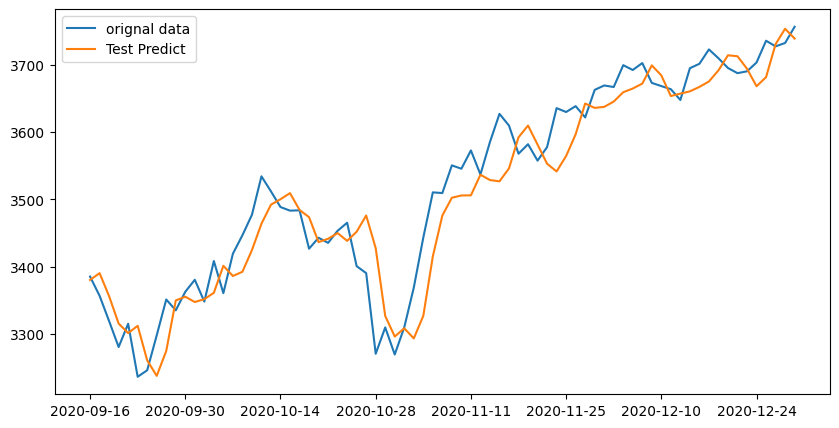

In [ ]:
# 计算 MSE 使用标准化后的数据
train_mse_combined = mean_squared_error(y_train_combined, train_preds_combined)
test_mse_combined = mean_squared_error(y_test_combined, test_preds_combined)

# 转换回原始值
# train_preds = scaler.inverse_transform(np.array(train_preds_combined).reshape(-1, 1))
# test_preds = scaler.inverse_transform(np.array(test_preds_combined).reshape(-1, 1))
train_preds_combined = np.array(train_preds_combined).reshape(-1, 1)
test_preds_combined = np.array(test_preds_combined).reshape(-1, 1)

print(f'Train MSE: {train_mse_combined}')
print(f'Test MSE: {test_mse_combined}')

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(df['Date'][train_size_combined + sequence_length+1:], scaler.inverse_transform(prices_scaled_combined[train_size_combined + sequence_length:]), label='orignal data')
plt.plot(df['Date'][train_size_combined + sequence_length+1:], scaler.inverse_transform(test_preds_combined), label='Test Predict')
plt.xticks(ticks=df['Date'][train_size_combined + sequence_length+1:][::10], rotation=0)
plt.legend()
plt.savefig("Index+Emo(GloVe).png", dpi=300, bbox_inches='tight')
plt.show()

#### (3) Add text & emotion

##### GloVe + DistilBERT

In [ ]:
import numpy as np

# 加载 GloVe 嵌入
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# 将单词标签转换为嵌入
def text_to_embedding(texts, embeddings_index, embed_dim):
    embeddings = []
    for text in texts:
        words = text.split()
        word_embeddings = np.zeros(embed_dim)
        count = 0
        for word in words:
            if word in embeddings_index:
                word_embeddings += embeddings_index[word]
                count += 1
        if count > 0:
            word_embeddings /= count
        embeddings.append(word_embeddings)
    return np.array(embeddings)

# 加载情感标签数据
df_emotion = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/train_stockemo.csv')
emotion_texts = df_emotion['emo_label'].astype(str).values
comment_texts = df_emotion['processed'].astype(str).values.tolist()
comment_texts

In [ ]:
# 合并情感数据
def aggregate_emotion(df_emotion, embeddings_index, embed_dim):
    df_emotion['embedding'] = text_to_embedding(df_emotion['emo_label'], embeddings_index, embed_dim).tolist()
    aggregated = df_emotion.groupby('date')['embedding'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
    return aggregated

# 处理情感数据
embed_dim = 50  # GloVe 嵌入维度
glove_file = '/content/drive/MyDrive/Sentiment Analysis/glove.6B.50d.txt'
embeddings_index = load_glove_embeddings(glove_file)

df_emotion_aggregated = aggregate_emotion(df_emotion, embeddings_index, embed_dim)

# 处理文本数据并生成DistilBERT嵌入
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def get_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

text_embeddings = get_bert_embeddings(comment_texts)

df_emotion['bert_embedding'] = text_embeddings.tolist()


In [ ]:
# 合并价格数据和情感数据
df['date'] = pd.to_datetime(df['Date'])
df_emotion_aggregated['date'] = pd.to_datetime(df_emotion_aggregated['date'])
df_combined = pd.merge(df, df_emotion_aggregated, on='date', how='left')

# 将DistilBERT嵌入合并到df_combined
df_emotion_aggregated_bert = df_emotion.groupby('date')['bert_embedding'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
df_emotion_aggregated_bert['date'] = pd.to_datetime(df_emotion_aggregated_bert['date'])
df_combined = pd.merge(df_combined, df_emotion_aggregated_bert, on='date', how='left')

# 处理缺失值
df_combined.dropna(inplace=True)

In [ ]:
with open('/content/drive/MyDrive/Sentiment Analysis/df_combined_text_emotion(GloVe).pkl', 'rb') as file:
    df_combined = pickle.load(file)
print("DataFrame已从dataframe.pkl文件中加载")

# 提取价格和情感嵌入
prices_combined = df_combined['Close'].values
emotion_embeddings_combined = np.array(df_combined['embedding'].tolist())
text_embeddings_combined = np.array(df_combined['bert_embedding'].tolist())

# 使用PCA降维
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
emotion_embeddings_combined = pca.fit_transform(emotion_embeddings_combined)
# print(emotion_embeddings_combined)
text_embeddings_combined = pca.fit_transform(text_embeddings_combined)
te_combined = np.hstack([emotion_embeddings_combined, text_embeddings_combined])
te_combined = pca.fit_transform(te_combined)
# print(te_combined)

# 标准化价格数据
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled_combined = scaler.fit_transform(prices_combined.reshape(-1, 1))

# 数据准备函数
def prepare_data_with_emotion_and_text(prices, texts, sequence_length):
    X, y = [], []
    for i in range(len(prices) - sequence_length):
        price_seq = prices[i:i+sequence_length]
        # emotion_seq = emotions[i:i+sequence_length]
        text_seq = texts[i:i+sequence_length]
        combined_seq = np.hstack([price_seq, text_seq])
        X.append(combined_seq)
        y.append(prices[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 3
X_combined, y_combined = prepare_data_with_emotion_and_text(prices_scaled_combined, te_combined, sequence_length)

# 划分数据集
train_size_combined = int(len(X_combined) * 0.7)
X_train_combined, X_test_combined = X_combined[:train_size_combined], X_combined[train_size_combined:]
y_train_combined, y_test_combined = y_combined[:train_size_combined], y_combined[train_size_combined:]

# 转换为 PyTorch 张量
X_train_combined_torch = torch.FloatTensor(X_train_combined)
X_test_combined_torch = torch.FloatTensor(X_test_combined)
y_train_combined_torch = torch.FloatTensor(y_train_combined)
y_test_combined_torch = torch.FloatTensor(y_test_combined)

DataFrame已从dataframe.pkl文件中加载


In [ ]:
test_mse = []
times = 1
for j in range(times):
  class Attention(nn.Module):
      def __init__(self, hidden_size):
          super(Attention, self).__init__()
          self.Wa = nn.Linear(hidden_size, hidden_size)
          self.Ua = nn.Linear(hidden_size, hidden_size)
          self.Va = nn.Linear(hidden_size, 1)

      def forward(self, lstm_out):
          scores = self.Va(torch.tanh(self.Wa(lstm_out) + self.Ua(lstm_out)))
          attention_weights = torch.softmax(scores, dim=1)
          context_vector = torch.sum(attention_weights * lstm_out, dim=1)
          return context_vector

  class TemporalAttentionLSTM(nn.Module):
      def __init__(self, input_size=1, hidden_layer_size=25, output_size=1):
          super(TemporalAttentionLSTM, self).__init__()
          self.hidden_layer_size = hidden_layer_size
          self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
          self.attention = Attention(hidden_layer_size)
          self.linear = nn.Linear(hidden_layer_size, output_size)
          self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                              torch.zeros(1, 1, self.hidden_layer_size))

      def forward(self, input_seq):
          lstm_out, self.hidden_cell = self.lstm(input_seq)
          context_vector = self.attention(lstm_out)
          predictions = self.linear(context_vector)
          return predictions

  # 实例化模型、定义损失函数和优化器
  input_size_combined = X_train_combined_torch.shape[2]  # X_train_combined 的特征维度
  model_combined = TemporalAttentionLSTM(input_size=input_size_combined, hidden_layer_size=100, output_size=1)
  loss_function_combined = nn.MSELoss()
  optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.01)

  # 训练模型
  epochs =400
  for i in range(epochs):
      model_combined.train()
      optimizer_combined.zero_grad()
      y_pred_combined = model_combined(X_train_combined_torch)
      single_loss_combined = loss_function_combined(y_pred_combined, y_train_combined_torch)
      single_loss_combined.backward()
      optimizer_combined.step()
      # if i % 10 == 0:
      #     print(f'Epoch {i} Loss: {single_loss_combined.item()}')

  # 预测
  model_combined.eval()
  train_preds_combined = []
  test_preds_combined = []

  with torch.no_grad():
      for seq in X_train_combined_torch:
          train_preds_combined.append(model_combined(seq.unsqueeze(0)).item())

      for seq in X_test_combined_torch:
          test_preds_combined.append(model_combined(seq.unsqueeze(0)).item())

  mse = mean_squared_error(y_test_combined, test_preds_combined)
  print(f'epoch {j+1} mse: {mse}')
  test_mse.append(mse)
print(f'Test MSE: {sum(test_mse)/times}')

epoch 1 mse: 0.0010608193440829717
Test MSE: 0.0010608193440829717


Train MSE: 0.001421664970295627
Test MSE: 0.0010608193440829717


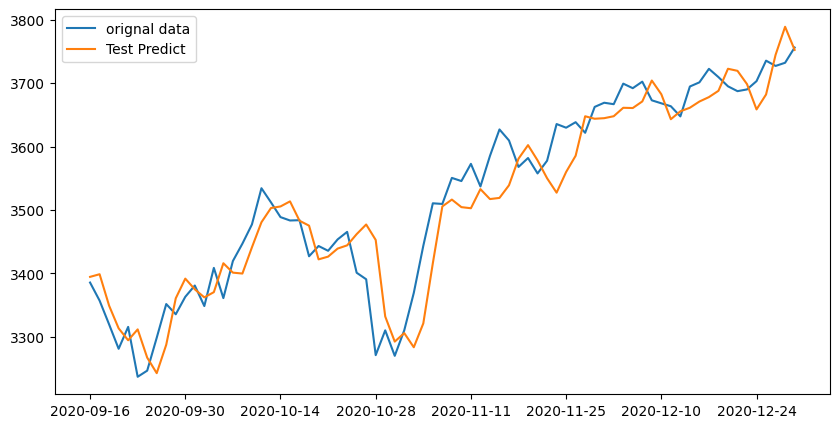

In [ ]:
# 计算 MSE 使用标准化后的数据
train_mse_combined = mean_squared_error(y_train_combined, train_preds_combined)
test_mse_combined = mean_squared_error(y_test_combined, test_preds_combined)

# 转换回原始值
# train_preds = scaler.inverse_transform(np.array(train_preds_combined).reshape(-1, 1))
# test_preds = scaler.inverse_transform(np.array(test_preds_combined).reshape(-1, 1))
train_preds_combined = np.array(train_preds_combined).reshape(-1, 1)
test_preds_combined = np.array(test_preds_combined).reshape(-1, 1)

print(f'Train MSE: {train_mse_combined}')
print(f'Test MSE: {test_mse_combined}')

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(df['Date'][train_size_combined + sequence_length+1:], scaler.inverse_transform(prices_scaled_combined[train_size_combined + sequence_length:]), label='orignal data')
plt.plot(df['Date'][train_size_combined + sequence_length+1:], scaler.inverse_transform(test_preds_combined), label='Test Predict')
plt.xticks(ticks=df['Date'][train_size_combined + sequence_length+1:][::10], rotation=0)
plt.legend()
plt.savefig("Index+Text+Emo(GloVe).png", dpi=300, bbox_inches='tight')
plt.show()

##### One-Hot

In [ ]:
with open('/content/drive/MyDrive/Sentiment Analysis/df_combined_text_emotion(GloVe).pkl', 'rb') as file:
    df_combined = pickle.load(file)
print("DataFrame已从dataframe.pkl文件中加载")

df_emotion = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/train_stockemo.csv')

# 独热编码12维
def emo_2_vec(emotion):
    emo_list = ['ambiguous', 'amusement', 'anger', 'anxiety', 'belief', 'confusion',
                'depression', 'disgust', 'excitement', 'optimism', 'panic', 'surprise']
    idx = emo_list.index(emotion)
    return np.array([1 if i == idx else 0 for i in range(12)])

# 合并情感数据
def aggregate_emotion(df_emotion):
    # df_emotion['embedding'] = text_to_embedding(df_emotion['emo_label'], embeddings_index, embed_dim).tolist()
    df_emotion['emotion_embedding_diy'] = df_emotion['emo_label'].apply(emo_2_vec).tolist()
    aggregated = df_emotion.groupby('date')['emotion_embedding_diy'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0)).reset_index()
    return aggregated

# 处理情感数据
df_emotion_aggregated = aggregate_emotion(df_emotion)

# 合并价格数据和情感数据
df['date'] = pd.to_datetime(df['Date'])
df_emotion_aggregated['date'] = pd.to_datetime(df_emotion_aggregated['date'])

df_combined = pd.merge(df_combined, df_emotion_aggregated, on='date', how='left')
# 处理缺失值
df_combined.dropna(inplace=True)
# print(df_combined)

# 提取价格和情感嵌入
prices_combined = df_combined['Close'].values
emotion_embeddings_combined = np.array(df_combined['emotion_embedding_diy'].tolist())
text_embeddings_combined = np.array(df_combined['bert_embedding'].tolist())

# 使用PCA降维
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
emotion_embeddings_combined = pca.fit_transform(emotion_embeddings_combined)
# print(emotion_embeddings_combined)
text_embeddings_combined = pca.fit_transform(text_embeddings_combined)
te_combined = np.hstack([emotion_embeddings_combined, text_embeddings_combined])
te_combined = pca.fit_transform(te_combined)
# print(te_combined)

# 标准化价格数据
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled_combined = scaler.fit_transform(prices_combined.reshape(-1, 1))

# 数据准备函数
def prepare_data_with_emotion_and_text(prices, texts, sequence_length):
    X, y = [], []
    for i in range(len(prices) - sequence_length):
        price_seq = prices[i:i+sequence_length]
        # emotion_seq = emotions[i:i+sequence_length]
        text_seq = texts[i:i+sequence_length]
        combined_seq = np.hstack([price_seq, text_seq])
        X.append(combined_seq)
        y.append(prices[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 3
X_combined, y_combined = prepare_data_with_emotion_and_text(prices_scaled_combined, te_combined, sequence_length)

# 划分数据集
train_size_combined = int(len(X_combined) * 0.7)
X_train_combined, X_test_combined = X_combined[:train_size_combined], X_combined[train_size_combined:]
y_train_combined, y_test_combined = y_combined[:train_size_combined], y_combined[train_size_combined:]

# 转换为 PyTorch 张量
X_train_combined_torch = torch.FloatTensor(X_train_combined)
X_test_combined_torch = torch.FloatTensor(X_test_combined)
y_train_combined_torch = torch.FloatTensor(y_train_combined)
y_test_combined_torch = torch.FloatTensor(y_test_combined)

DataFrame已从dataframe.pkl文件中加载


In [ ]:
test_mse = []
times = 1
for j in range(times):
  class Attention(nn.Module):
      def __init__(self, hidden_size):
          super(Attention, self).__init__()
          self.Wa = nn.Linear(hidden_size, hidden_size)
          self.Ua = nn.Linear(hidden_size, hidden_size)
          self.Va = nn.Linear(hidden_size, 1)

      def forward(self, lstm_out):
          scores = self.Va(torch.tanh(self.Wa(lstm_out) + self.Ua(lstm_out)))
          attention_weights = torch.softmax(scores, dim=1)
          context_vector = torch.sum(attention_weights * lstm_out, dim=1)
          return context_vector

  class TemporalAttentionLSTM(nn.Module):
      def __init__(self, input_size=1, hidden_layer_size=25, output_size=1):
          super(TemporalAttentionLSTM, self).__init__()
          self.hidden_layer_size = hidden_layer_size
          self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
          self.attention = Attention(hidden_layer_size)
          self.linear = nn.Linear(hidden_layer_size, output_size)
          self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                              torch.zeros(1, 1, self.hidden_layer_size))

      def forward(self, input_seq):
          lstm_out, self.hidden_cell = self.lstm(input_seq)
          context_vector = self.attention(lstm_out)
          predictions = self.linear(context_vector)
          return predictions

  # 实例化模型、定义损失函数和优化器
  input_size_combined = X_train_combined_torch.shape[2]  # X_train_combined 的特征维度
  model_combined = TemporalAttentionLSTM(input_size=input_size_combined, hidden_layer_size=100, output_size=1)
  loss_function_combined = nn.MSELoss()
  optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.01)

  # 训练模型
  epochs =400
  for i in range(epochs):
      model_combined.train()
      optimizer_combined.zero_grad()
      y_pred_combined = model_combined(X_train_combined_torch)
      single_loss_combined = loss_function_combined(y_pred_combined, y_train_combined_torch)
      single_loss_combined.backward()
      optimizer_combined.step()
      # if i % 10 == 0:
      #     print(f'Epoch {i} Loss: {single_loss_combined.item()}')

  # 预测
  model_combined.eval()
  train_preds_combined = []
  test_preds_combined = []

  with torch.no_grad():
      for seq in X_train_combined_torch:
          train_preds_combined.append(model_combined(seq.unsqueeze(0)).item())

      for seq in X_test_combined_torch:
          test_preds_combined.append(model_combined(seq.unsqueeze(0)).item())

  mse = mean_squared_error(y_test_combined, test_preds_combined)
  print(f'epoch {j+1} mse: {mse}')
  test_mse.append(mse)
print(f'Test MSE: {sum(test_mse)/times}')

epoch 1 mse: 0.0007759196381994758
Test MSE: 0.0007759196381994758


Train MSE: 0.0015359245699095093
Test MSE: 0.0007759196381994758


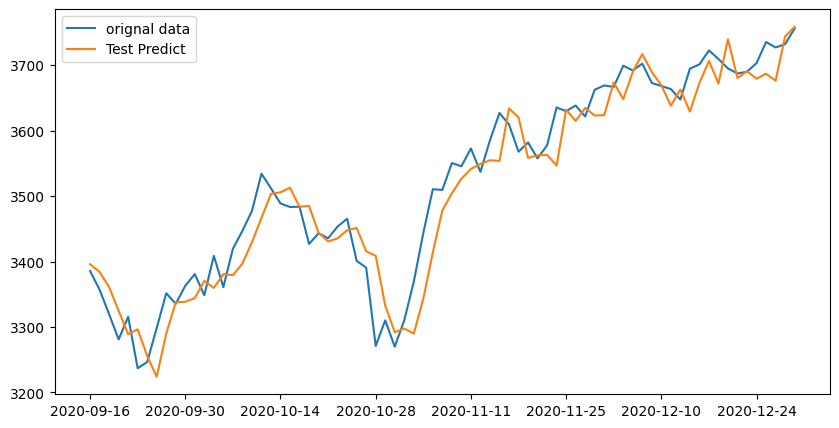

In [ ]:
# 计算 MSE 使用标准化后的数据
train_mse_combined = mean_squared_error(y_train_combined, train_preds_combined)
test_mse_combined = mean_squared_error(y_test_combined, test_preds_combined)

# 转换回原始值
# train_preds = scaler.inverse_transform(np.array(train_preds_combined).reshape(-1, 1))
# test_preds = scaler.inverse_transform(np.array(test_preds_combined).reshape(-1, 1))
train_preds_combined = np.array(train_preds_combined).reshape(-1, 1)
test_preds_combined = np.array(test_preds_combined).reshape(-1, 1)

print(f'Train MSE: {train_mse_combined}')
print(f'Test MSE: {test_mse_combined}')

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(df['Date'][train_size_combined + sequence_length+1:], scaler.inverse_transform(prices_scaled_combined[train_size_combined + sequence_length:]), label='orignal data')
plt.plot(df['Date'][train_size_combined + sequence_length+1:], scaler.inverse_transform(test_preds_combined), label='Test Predict')
plt.xticks(ticks=df['Date'][train_size_combined + sequence_length+1:][::10], rotation=0)
plt.legend()
plt.savefig("Index+Text+Emo(One-Hot).png", dpi=300, bbox_inches='tight')
plt.show()

#### (4) Add text

In [ ]:
with open('/content/drive/MyDrive/Sentiment Analysis/df_combined_text_emotion(GloVe).pkl', 'rb') as file:
    df_combined = pickle.load(file)

print("DataFrame已从dataframe.pkl文件中加载")

# 提取价格和情感嵌入
prices_combined = df_combined['Close'].values
# emotion_embeddings_combined = np.array(df_combined['embedding'].tolist())
text_embeddings_combined = np.array(df_combined['bert_embedding'].tolist())

# 使用PCA降维
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
# emotion_embeddings_combined = pca.fit_transform(emotion_embeddings_combined)
text_embeddings_combined = pca.fit_transform(text_embeddings_combined)

# 标准化价格数据
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled_combined = scaler.fit_transform(prices_combined.reshape(-1, 1))

# 数据准备函数
def prepare_data_with_emotion_and_text(prices, texts, sequence_length):
    X, y = [], []
    for i in range(len(prices) - sequence_length):
        price_seq = prices[i:i+sequence_length]
        # emotion_seq = emotions[i:i+sequence_length]
        text_seq = texts[i:i+sequence_length]
        combined_seq = np.hstack([price_seq, text_seq])
        X.append(combined_seq)
        y.append(prices[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 3
X_combined, y_combined = prepare_data_with_emotion_and_text(prices_scaled_combined, text_embeddings_combined, sequence_length)

# 划分数据集
train_size_combined = int(len(X_combined) * 0.7)
X_train_combined, X_test_combined = X_combined[:train_size_combined], X_combined[train_size_combined:]
y_train_combined, y_test_combined = y_combined[:train_size_combined], y_combined[train_size_combined:]

# 转换为 PyTorch 张量
X_train_combined_torch = torch.FloatTensor(X_train_combined)
X_test_combined_torch = torch.FloatTensor(X_test_combined)
y_train_combined_torch = torch.FloatTensor(y_train_combined)
y_test_combined_torch = torch.FloatTensor(y_test_combined)

DataFrame已从dataframe.pkl文件中加载


In [ ]:
test_mse = []
times=1
for j in range(times):
  class Attention(nn.Module):
      def __init__(self, hidden_size):
          super(Attention, self).__init__()
          self.Wa = nn.Linear(hidden_size, hidden_size)
          self.Ua = nn.Linear(hidden_size, hidden_size)
          self.Va = nn.Linear(hidden_size, 1)

      def forward(self, lstm_out):
          scores = self.Va(torch.tanh(self.Wa(lstm_out) + self.Ua(lstm_out)))
          attention_weights = torch.softmax(scores, dim=1)
          context_vector = torch.sum(attention_weights * lstm_out, dim=1)
          return context_vector

  class TemporalAttentionLSTM(nn.Module):
      def __init__(self, input_size=1, hidden_layer_size=25, output_size=1):
          super(TemporalAttentionLSTM, self).__init__()
          self.hidden_layer_size = hidden_layer_size
          self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
          self.attention = Attention(hidden_layer_size)
          self.linear = nn.Linear(hidden_layer_size, output_size)
          self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                              torch.zeros(1, 1, self.hidden_layer_size))

      def forward(self, input_seq):
          lstm_out, self.hidden_cell = self.lstm(input_seq)
          context_vector = self.attention(lstm_out)
          predictions = self.linear(context_vector)
          return predictions

  # 实例化模型、定义损失函数和优化器
  input_size_combined = X_train_combined_torch.shape[2]  # X_train_combined 的特征维度
  model_combined = TemporalAttentionLSTM(input_size=input_size_combined, hidden_layer_size=100, output_size=1)
  loss_function_combined = nn.MSELoss()
  optimizer_combined = optim.Adam(model_combined.parameters(), lr=0.01)

  # 训练模型
  epochs =400
  for i in range(epochs):
      model_combined.train()
      optimizer_combined.zero_grad()
      y_pred_combined = model_combined(X_train_combined_torch)
      single_loss_combined = loss_function_combined(y_pred_combined, y_train_combined_torch)
      single_loss_combined.backward()
      optimizer_combined.step()
      # if i % 10 == 0:
      #     print(f'Epoch {i} Loss: {single_loss_combined.item()}')

  # 预测
  model_combined.eval()
  train_preds_combined = []
  test_preds_combined = []

  with torch.no_grad():
      for seq in X_train_combined_torch:
          train_preds_combined.append(model_combined(seq.unsqueeze(0)).item())

      for seq in X_test_combined_torch:
          test_preds_combined.append(model_combined(seq.unsqueeze(0)).item())

  mse = mean_squared_error(y_test_combined, test_preds_combined)
  print(f'epoch {j+1} mse: {mse}')
  test_mse.append(mse)

print(f'Test MSE: {sum(test_mse)/times}')

epoch 1 mse: 0.0010727867177018793
Test MSE: 0.0010727867177018793


Train MSE: 0.0017047282386744432
Test MSE: 0.0010727867177018793


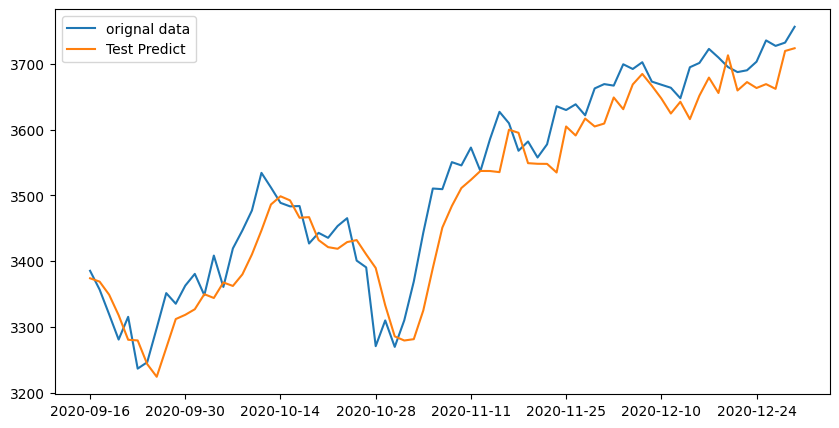

In [ ]:
# 计算 MSE 使用标准化后的数据
train_mse_combined = mean_squared_error(y_train_combined, train_preds_combined)
test_mse_combined = mean_squared_error(y_test_combined, test_preds_combined)

# 转换回原始值
# train_preds = scaler.inverse_transform(np.array(train_preds_combined).reshape(-1, 1))
# test_preds = scaler.inverse_transform(np.array(test_preds_combined).reshape(-1, 1))
train_preds_combined = np.array(train_preds_combined).reshape(-1, 1)
test_preds_combined = np.array(test_preds_combined).reshape(-1, 1)

print(f'Train MSE: {train_mse_combined}')
print(f'Test MSE: {test_mse_combined}')

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(df['Date'][train_size_combined + sequence_length+1:], scaler.inverse_transform(prices_scaled_combined[train_size_combined + sequence_length:]), label='orignal data')
plt.plot(df['Date'][train_size_combined + sequence_length+1:], scaler.inverse_transform(test_preds_combined), label='Test Predict')
plt.xticks(ticks=df['Date'][train_size_combined + sequence_length+1:][::10], rotation=0)
plt.legend()
plt.savefig("Index+Text.png", dpi=300, bbox_inches='tight')
plt.show()